# Important Traffic Nodes

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/10 14:51:50 WARN Utils: Your hostname, amin-X556UQK resolves to a loopback address: 127.0.1.1; using 192.168.1.15 instead (on interface wlp3s0)
22/02/10 14:51:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/10 14:51:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



### Keep only 7 days

In [4]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



### Remove outliers

In [5]:
from pyspark.sql.functions import count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|     803001|      102|        7631929|      7631929|               6|       161|2021-06-01 10:37:55|152|    1|
|   22010048|      284|        7631930|      7631930|               5|       161|2021-06-02 13:21:00|153|    1|
|     900158|      283|        7631979|      7631979|               5|       264|2021-06-06 12:30:50|157|    9|
|  100700881|      283|        7631979|      7631979|               5|       264|2021-06-06 17:46:08|157|    9|
|     900222|      283|        7631979|      7631979|               5|       264|2021-06-06 17:49:52|157|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

In [6]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

df_cleaned_indexed = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(df_cleaned).transform(df_cleaned)
df_cleaned_indexed = df_cleaned_indexed.withColumn('camera', df_cleaned_indexed['camera'].cast(IntegerType()))
df_cleaned_indexed.show(5)

TypeError: unexpected type: <class 'pyspark.sql.types.DataTypeSingleton'>

In [6]:
from pyspark.sql.functions import dayofyear, lead

df_with_day = df_cleaned.withColumn('day', dayofyear(df.PASS_DAY_TIME))

window = Window.partitionBy('FINAL_CAR_KEY', 'day').orderBy('FINAL_CAR_KEY','PASS_DAY_TIME')
df_with_next = df_with_day.withColumn('next', lead('camera', offset=1,  default=-1).over(window))
df_with_next = df_with_next.filter(df_with_next.next != -1).select('FINAL_CAR_KEY', 'day', 'camera', 'next')
df_with_next.show(5)

+-------------+---+-----------+--------+
|FINAL_CAR_KEY|day|DEVICE_CODE|    next|
+-------------+---+-----------+--------+
|      7631984|154|     631781|     114|
|      7631984|154|        114|  900130|
|      7631984|154|     900130|22009923|
|      7631984|154|   22009923|  203001|
|      7631984|154|     203001|     150|
+-------------+---+-----------+--------+
only showing top 5 rows



In [22]:
graph_df = df_with_next.groupBy(
    'DEVICE_CODE',
    'next'
).count()
graph_df.show(5)

+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     900265|  35| 1608|
|     631361|  89|  910|
|     900216|  55| 1758|
|  100700901|  62|   54|
|  100700845|   6|  886|
+-----------+----+-----+
only showing top 5 rows



In [24]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(graph_df.rdd.map(lambda x: (int(x['camera']), int(x['next']), x['count']) ))

In [25]:
svd = utility_matrix.toRowMatrix().computeSVD(10, computeU=True)
u = svd.U
s = svd.s
v = svd.V
print(u)
print(s)
print(v)

22/02/08 13:13:33 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
22/02/08 13:13:33 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK


[188271.66600858152,31726.72347411335,25917.749195161658,21968.311152889397,17315.48081317604,12812.607827985737,11410.508727943672,10785.918588789793,10121.951375287717,9251.080116445459]
DenseMatrix([[-0.02181479, -0.03166442, -0.01210924, ..., -0.04270199,
               0.00184222, -0.00566491],
             [-0.01454072, -0.02258541, -0.00869482, ..., -0.03088935,
              -0.00571353, -0.00974713],
             [-0.00793662, -0.01203552, -0.00470303, ..., -0.01798502,
              -0.00365916, -0.00681527],
             ...,
             [-0.08776691, -0.06104443, -0.07625721, ..., -0.07529783,
              -0.0101488 ,  0.07204838],
             [-0.04132909, -0.04295587, -0.02342279, ..., -0.0502602 ,
              -0.01153339,  0.00519515],
             [-0.02994968, -0.03864455, -0.01633105, ..., -0.04683206,
              -0.01384041,  0.00087887]])


22/02/08 13:13:48 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [26]:
hubs = u.rows.map(lambda x: x.toArray()[0] * -1).collect()
auths = v.toArray()
auths = auths[:,0] * -1
print(auths)
print('number of hubs: ', len(hubs))
print('number of auth: ', len(auths))

print('hubs ratings: ', hubs)
print('auths ratings: ', auths)

<class 'pyspark.mllib.linalg.DenseVector'>
[0.02181479 0.01454072 0.00793662 0.00851296 0.00693132 0.01020027
 0.02402674 0.03472469 0.04307125 0.05354024 0.07011996 0.08389912
 0.08828023 0.0827309  0.07438185 0.06850134 0.0776734  0.09364762
 0.10489966 0.11317219 0.10632912 0.09308412 0.04377043 0.03207097
 0.02104613 0.01301153 0.00719644 0.00745724 0.00836839 0.0274353
 0.0887322  0.11821339 0.1079991  0.09495844 0.09494098 0.09045897
 0.09061063 0.08916523 0.0975633  0.10176703 0.11784781 0.12134168
 0.11806536 0.11859147 0.10962182 0.0832641  0.03482951 0.02823373
 0.01707337 0.00965662 0.00535823 0.00551635 0.00698724 0.02422431
 0.08161567 0.11448726 0.10452615 0.09061134 0.09291748 0.09651075
 0.09354661 0.08772409 0.09585697 0.09819274 0.11807692 0.11873505
 0.11299549 0.11462013 0.10455745 0.08774597 0.0424666  0.02920635
 0.01839301 0.01043588 0.00571154 0.0057729  0.00732415 0.02548413
 0.08851679 0.12266528 0.1120539  0.10312267 0.10191877 0.09816262
 0.09413808 0.090237

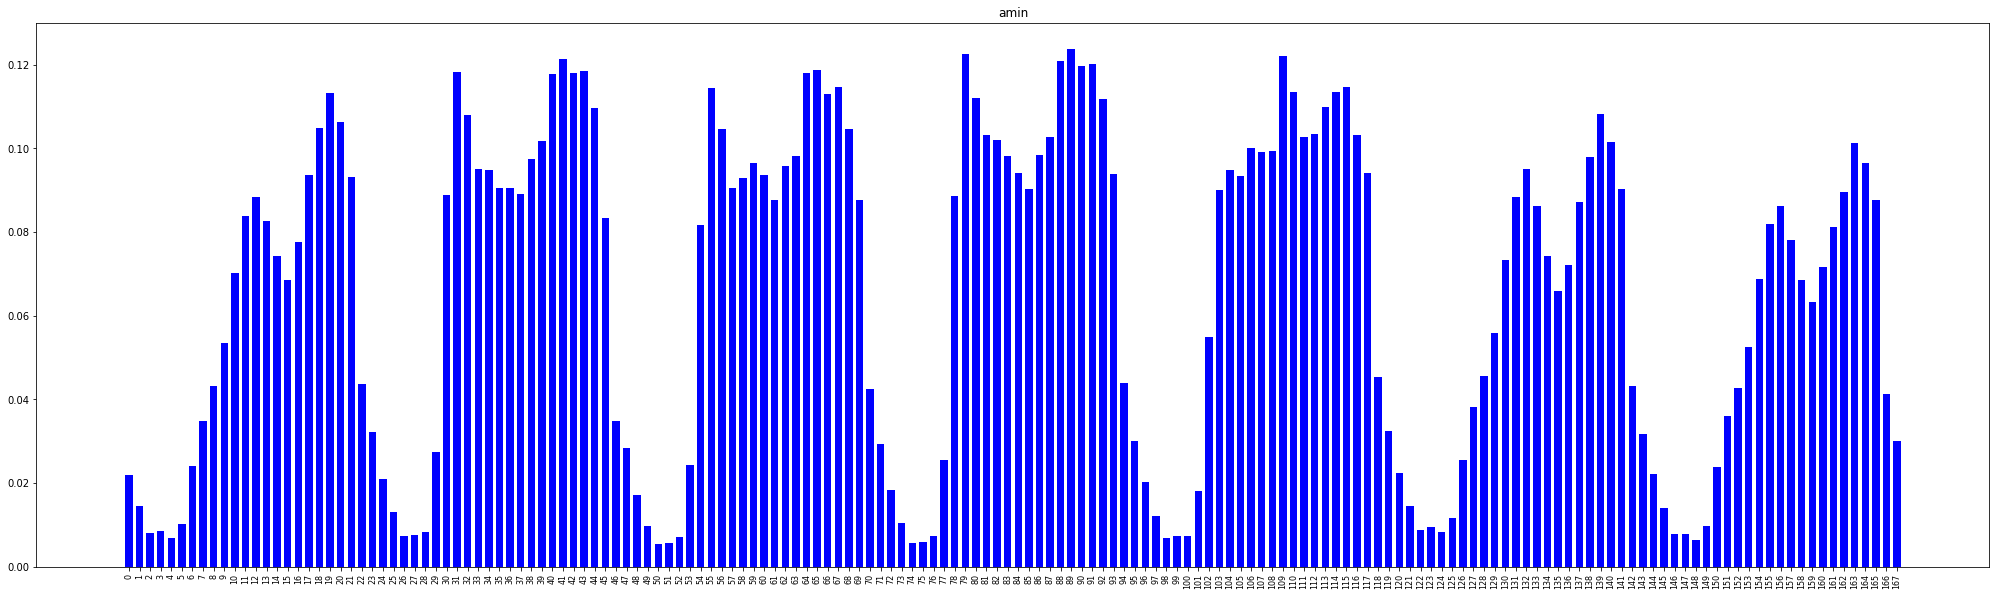

In [31]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (40, 10))
label_list = list(map(lambda x: str(x), range(len(auths))))
plt.bar(label_list, auths, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('auths')
plt.show()

In [ ]:
# from matplotlib import pyplot as plt

# weekdays = [
#     'sunday',
#     'monday',
#     'tuesday',
#     'wednesday',
#     'thursday',
#     'friday',
#     'saturday',
#     ]

# for day_index, day in enumerate(weekdays):
#     fig = plt.figure(figsize = (40, 8))
#     labels = list(map(lambda x: str(x), range(24)))
#     chart = times[day_index*24: (day_index+1)*24]
#     plt.bar(labels, chart, color ='blue', width = 0.7)
#     plt.xticks(rotation='vertical',fontsize=8)
#     plt.title(day)
#     plt.show()